# **1. Import**

In [1]:
# import libraries
import pandas as pd
import numpy as np
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

ModuleNotFoundError: No module named 'seaborn'

# **2. Read Data**

In [2]:
data = pd.read_csv('tech_challenge2021_train.csv')

# **3. Glimps Data**

In [3]:
data.sample(10)

,Well Identifier,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
32973,USROP_A 2 N-SH_F-14d,1674.788,6.261057,15769.00025,13.300001,39.910000,159.750000,4096.740235,1.250000,444.5,129.228639,1674.297794,75.973
91853,USROP_A 3 N-SH-F-15d,2748.851,4.354487,13583.08555,19.550895,19.406616,139.736000,2121.382739,10.849026,215.9,128.067270,2556.961714,29.130
184225,USROP_A 5 N-SH-F-5d,3489.198,4.394977,21486.99951,26.240000,48.990002,179.949997,2089.270018,1.460000,215.9,143.055981,3065.952110,34.660
71952,USROP_A 3 N-SH-F-15d,1418.423,1.442424,22966.09181,8.446746,14.240256,100.000000,4453.120823,11.933929,444.5,124.388636,1385.386104,135.690
86222,USROP_A 3 N-SH-F-15d,1828.687,2.340537,24714.74015,12.500641,20.778216,129.280000,4453.120823,12.017384,444.5,132.580514,1763.286288,109.190
194044,USROP_A 6 N-SH_F-9d,349.758,3.314078,14463.00049,3.330000,49.310001,212.000000,4426.580076,1.030000,444.5,96.679291,349.747027,72.495
30562,USROP_A 2 N-SH_F-14d,1535.683,2.539094,14499.00055,8.610000,25.190001,160.639999,3965.040039,1.250000,444.5,128.249705,1535.193170,89.929
53044,USROP_A 2 N-SH_F-14d,2848.204,10.095190,16691.00037,11.500000,7.980000,139.860001,1985.189941,1.320000,215.9,138.640623,2776.040066,20.193
50197,USROP_A 2 N-SH_F-14d,2764.688,4.547934,13677.00043,7.050000,19.450001,69.650002,1674.989990,1.300000,215.9,139.130082,2713.802954,8.550
155232,USROP_A 4 N-SH_F-15Sd,3494.453,13.435406,21689.45855,17.449377,24.307800,253.070000,2016.072577,1.330000,215.9,132.879885,2829.688524,11.140


In [4]:
data.describe()

,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
count,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000
mean,2411.781370,6.087997,17451.302922,14.430343,24.978426,152.368019,2873.576072,4.008286,297.470693,127.503708,2153.624785,67.197939
std,1066.443448,3.957126,4236.531326,7.239629,15.086731,49.998842,1055.406219,4.496288,100.344171,15.551890,846.519288,50.519888
min,225.171000,0.001814,1432.661618,0.008135,0.330000,0.000000,185.420836,1.020000,215.900000,84.047945,225.162770,0.000000
25%,1548.686750,3.283486,14655.999760,9.639866,12.990000,129.250000,1993.927917,1.300000,215.900000,124.925435,1516.593360,25.380000
50%,2697.182500,5.190356,16683.999630,12.798921,21.090000,139.736000,2121.382739,1.350000,215.900000,130.905851,2528.949222,54.490000
75%,3288.946500,8.127138,21153.529060,17.815448,32.470001,179.283000,3987.855834,10.849026,444.500000,138.719433,2865.091577,98.140000
max,4090.001000,31.411272,24998.459410,36.489128,99.206304,311.230011,4538.450195,12.017384,444.500000,152.926842,3248.389893,260.899000


# **4. Exploratory Data Analysis**

In [7]:
# remove all rows that contains missing value
data.replace(['-999', -999], np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
data.describe()

,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
count,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000
mean,2411.781370,6.087997,17451.302922,14.430343,24.978426,152.368019,2873.576072,4.008286,297.470693,127.503708,2153.624785,67.197939
std,1066.443448,3.957126,4236.531326,7.239629,15.086731,49.998842,1055.406219,4.496288,100.344171,15.551890,846.519288,50.519888
min,225.171000,0.001814,1432.661618,0.008135,0.330000,0.000000,185.420836,1.020000,215.900000,84.047945,225.162770,0.000000
25%,1548.686750,3.283486,14655.999760,9.639866,12.990000,129.250000,1993.927917,1.300000,215.900000,124.925435,1516.593360,25.380000
50%,2697.182500,5.190356,16683.999630,12.798921,21.090000,139.736000,2121.382739,1.350000,215.900000,130.905851,2528.949222,54.490000
75%,3288.946500,8.127138,21153.529060,17.815448,32.470001,179.283000,3987.855834,10.849026,444.500000,138.719433,2865.091577,98.140000
max,4090.001000,31.411272,24998.459410,36.489128,99.206304,311.230011,4538.450195,12.017384,444.500000,152.926842,3248.389893,260.899000


In [8]:
data.isna().any()

Well Identifier                   False
Measured Depth m                  False
Weight on Bit kkgf                False
Average Standpipe Pressure kPa    False
Average Surface Torque kN.m       False
Rate of Penetration m/h           False
Average Rotary Speed rpm          False
Mud Flow In L/min                 False
Mud Density In g/cm3              False
Diameter mm                       False
Average Hookload kkgf             False
Hole Depth (TVD) m                False
USROP Gamma gAPI                  False
dtype: bool

In [9]:
wells = data['Well Identifier'].unique()
wells

array(['USROP_A 0 N-NA_F-9_Ad', 'USROP_A 1 N-S_F-7d',
       'USROP_A 2 N-SH_F-14d', 'USROP_A 3 N-SH-F-15d',
       'USROP_A 4 N-SH_F-15Sd', 'USROP_A 5 N-SH-F-5d',
       'USROP_A 6 N-SH_F-9d'], dtype=object)

In [10]:
len(wells)

7

In [11]:
data.columns.tolist()

['Well Identifier',
 'Measured Depth m',
 'Weight on Bit kkgf',
 'Average Standpipe Pressure kPa',
 'Average Surface Torque kN.m',
 'Rate of Penetration m/h',
 'Average Rotary Speed rpm',
 'Mud Flow In L/min',
 'Mud Density In g/cm3',
 'Diameter mm',
 'Average Hookload kkgf',
 'Hole Depth (TVD) m',
 'USROP Gamma gAPI']

### Look at some log curves for a couple of wells

(1205.999, 491.033)

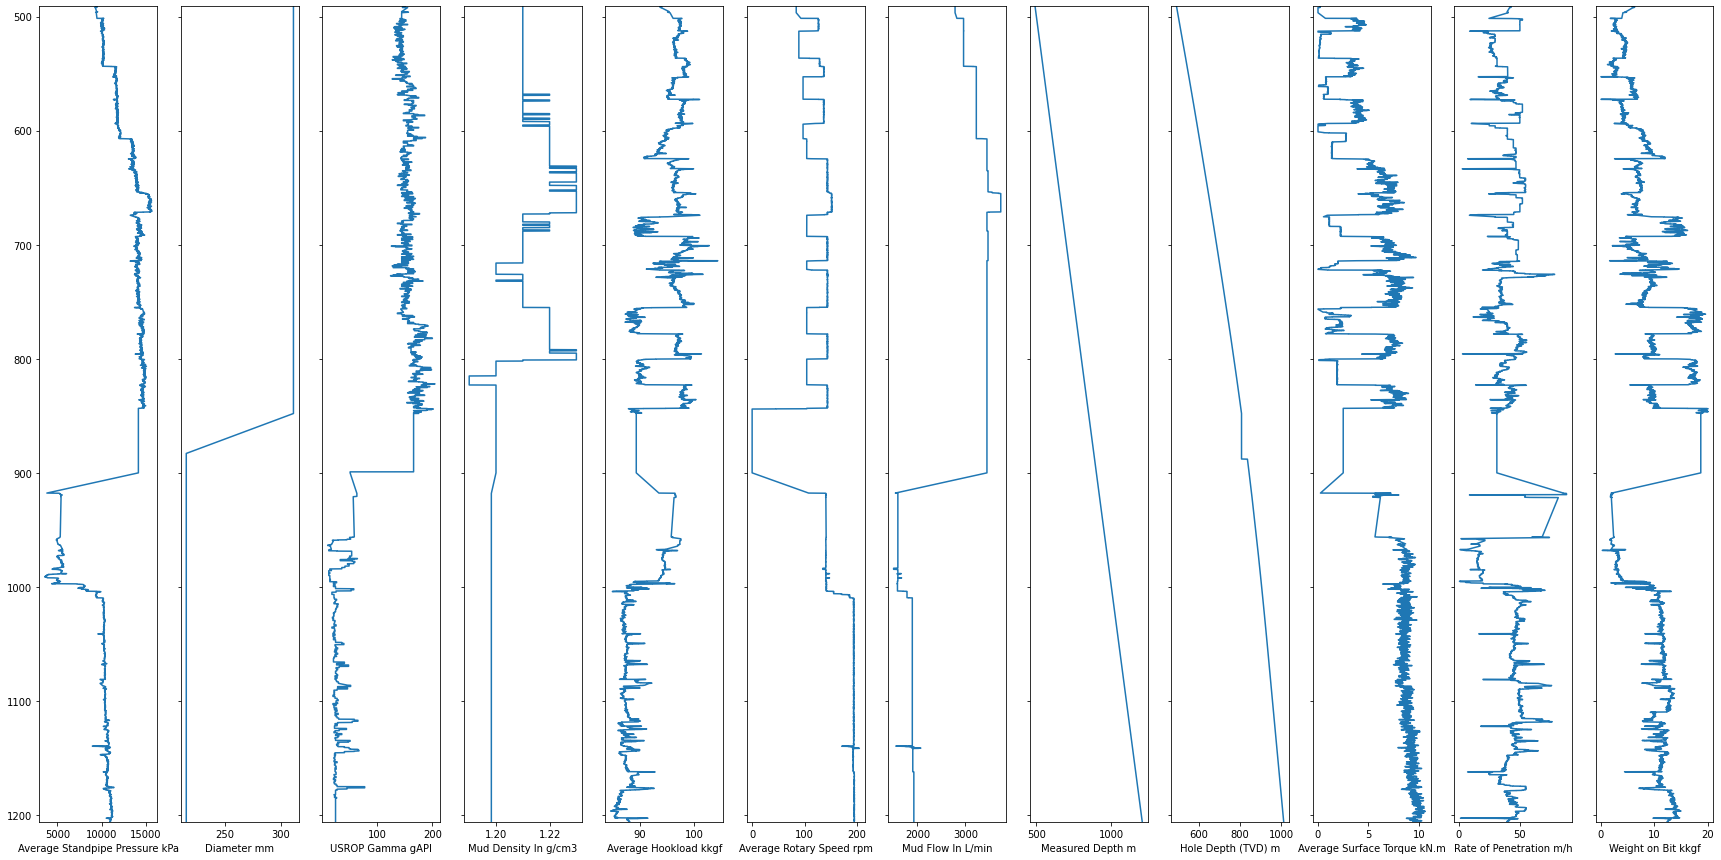

In [12]:
well_data = data[data['Well Identifier'] == wells[0]]
fig, axs = plt.subplots(1, len(well_data.columns)-1, figsize=(30, 15), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['Well Identifier'])):
 axs[ic].plot(well_data[col], well_data['Measured Depth m'])
 axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['Measured Depth m'].values[-1], well_data['Measured Depth m'].values[0])

(633.536, 301.231)

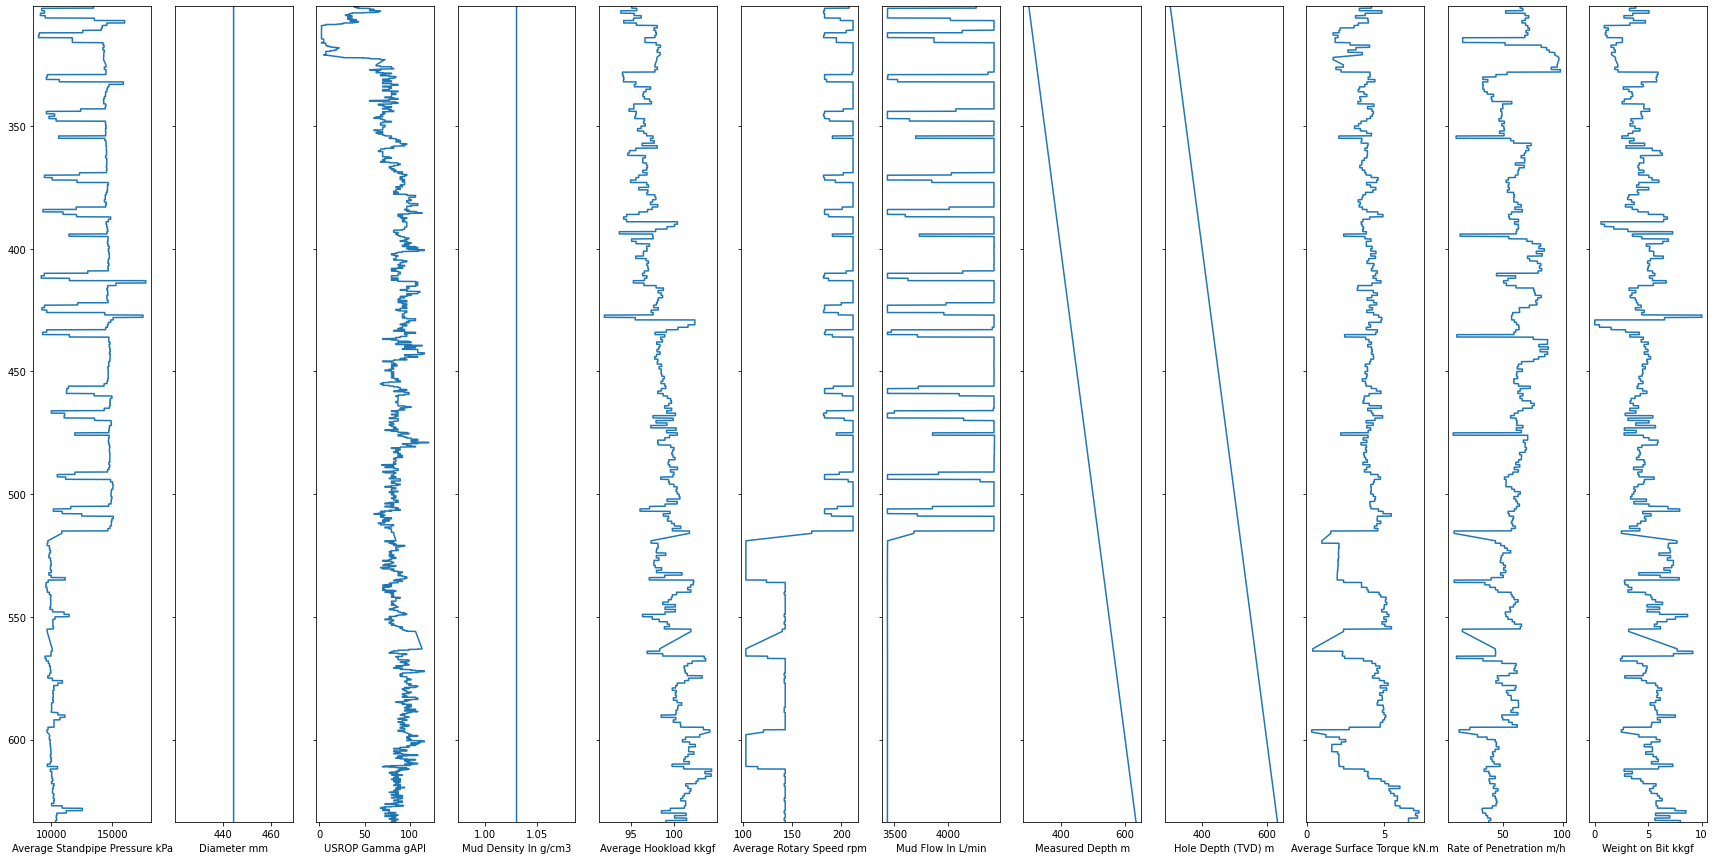

In [13]:
well_data = data[data['Well Identifier'] == wells[1]]
fig, axs = plt.subplots(1, len(well_data.columns)-1, figsize=(30, 15), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['Well Identifier'])):
 axs[ic].plot(well_data[col], well_data['Measured Depth m'])
 axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['Measured Depth m'].values[-1], well_data['Measured Depth m'].values[0])

In [14]:
well_data.columns

Index(['Well Identifier', 'Measured Depth m', 'Weight on Bit kkgf',
       'Average Standpipe Pressure kPa', 'Average Surface Torque kN.m',
       'Rate of Penetration m/h', 'Average Rotary Speed rpm',
       'Mud Flow In L/min', 'Mud Density In g/cm3', 'Diameter mm',
       'Average Hookload kkgf', 'Hole Depth (TVD) m', 'USROP Gamma gAPI'],
      dtype='object')

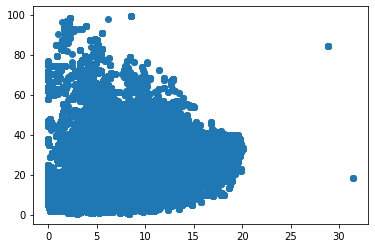

In [11]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
plt.scatter(data['Weight on Bit kkgf'], data['Rate of Penetration m/h'])

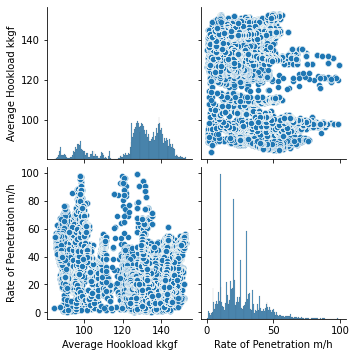

In [12]:
# another library from Seaborn to check the co-linearity
sb.pairplot(data[['Average Hookload kkgf', 'Rate of Penetration m/h']])

# **5. Build Machine Learning Models**

#### Preparing data for training

In [15]:
X = data.drop(columns=['Well Identifier', 'Rate of Penetration m/h'])

In [16]:
y = data['Rate of Penetration m/h']

####Shuffle the data


In [17]:
X, y = shuffle(X, y, random_state=42)

In [18]:
X

,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
95319,2886.816,11.920407,13747.38762,22.303205,139.736,2121.382739,10.849026,215.90,124.987378,2645.491178,7.350
99368,3024.293,6.128940,14811.55204,23.271259,139.736,2121.378954,11.182843,215.90,125.260440,2733.591790,14.002
131291,2012.594,5.333116,22280.20135,11.600000,124.140,3987.855834,1.450000,311.15,135.214376,1906.749552,103.520
162157,3748.516,3.304420,15244.43248,17.475138,179.505,1705.918630,1.310000,215.90,140.589594,2945.014786,57.565
97546,2966.128,3.889101,14624.13875,21.763590,139.736,2121.378954,11.182843,215.90,126.296899,2697.390998,9.994
...,...,...,...,...,...,...,...,...,...,...,...
119879,4014.792,16.772031,16404.12376,32.389135,139.736,2077.184268,11.266297,215.90,134.440243,3150.273506,67.673
103694,3170.837,1.850657,16055.68341,16.283374,139.736,2121.382739,11.182843,215.90,132.571442,2810.914978,27.000
131932,2058.619,5.863368,22478.97720,11.270001,140.000,3987.855834,1.460000,311.15,135.642655,1946.937432,85.330
146867,3062.280,8.187342,19464.93405,11.876965,234.380,2016.072577,1.320000,215.90,130.639139,2654.130125,9.370


####Scale the features

In [19]:
scaler = StandardScaler()

In [20]:
X.columns

Index(['Measured Depth m', 'Weight on Bit kkgf',
       'Average Standpipe Pressure kPa', 'Average Surface Torque kN.m',
       'Average Rotary Speed rpm', 'Mud Flow In L/min', 'Mud Density In g/cm3',
       'Diameter mm', 'Average Hookload kkgf', 'Hole Depth (TVD) m',
       'USROP Gamma gAPI'],
      dtype='object')

In [21]:
X = scaler.fit_transform(X)

#### Split into train and test data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####Example prediction on open test dataset

In [23]:
model = RandomForestRegressor(n_estimators=50, random_state=42)

In [24]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

####Test model

In [25]:
y_pred_test = model.predict(X_test)

In [26]:
mean_absolute_error(y_test.values, y_pred_test)

0.1135034892569459

####Save model and scaler to files

In [27]:
pickle.dump(model, open('model.pkl', 'wb'))

In [28]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In order to make it easy to run inference on new data, such as the open test dataset, it is recommended to wrap the initialization of the model, all preprocessing steps including normalization, treatment of outliers and removals of unused columns in a class or pipeline. There are many ways of doing this, one example being a class like below:

In [ ]:
class Model(object):
    def __init__(self, model_file, scaler_file):
        # Load pre-trained model from file
        self.model = pickle.load(open(model_file, 'rb'))
        # Load a "pre-trained" scaler from file
        self.scaler = pickle.load(open(scaler_file, 'rb'))
        
    def _preprocess(self, features):
        # Method to be run before inference. Contains things like
        # stripping unwanted columns, replacing NaNs, and scaling 
        # or normalizing data
        features.fillna(0, inplace=True)
        features = features[['Measured Depth m','Weight on Bit kkgf','Average Standpipe Pressure kPa',
                             'Average Surface Torque kN.m','Average Rotary Speed rpm','Mud Flow In L/min',
                             'Mud Density In g/cm3','Diameter mm','Average Hookload kkgf','Hole Depth (TVD) m',
                             'USROP Gamma gAPI']]
        return self.scaler.transform(features)
        
    def predict(self, features):
        # This function should be able to take in features in their
        # raw, unprocessed form as read from the file test.csv and
        # return predictions as an array integers of the same length
        X = self._preprocess(features)
        return self.model.predict(X)

The model can then be initialized using persisted data in the form of saved model file (or models files), scaler files, and other persisted data. 

In [ ]:
model = Model('model.pkl', 'scaler.pkl')

# **6. Example submission: Daily leaderboard**

For the daily leaderboard that will start April 1st, you are asked to submit predictions on the supplied open dataset in the file test.csv. This file contains all the columns that are in the training data except Rate of Penetration. Notice that the test data will also have missing columns. It is therefore important that your inference pipeline has the treatment of these missing columns as part of the pre-processing step.

In [30]:
open_test_features = pd.read_csv('tech_challenge2021_test.csv')

In [39]:
open_test_features.head()

,Well Identifier,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
0,TC-2021-TW,365.150,10.656246,23053.9448,22.631313,169.781,3491.436904,1.31,254.0,136.662392,365.124187,20.774
1,TC-2021-TW,365.303,10.656246,23053.9448,22.631313,169.781,3491.436904,1.31,254.0,136.662392,365.276587,20.774
2,TC-2021-TW,365.455,10.656246,23053.9448,22.631313,169.781,3491.436904,1.31,254.0,136.662392,365.428682,20.774
3,TC-2021-TW,365.608,10.656246,23053.9448,22.631313,169.781,3491.436904,1.31,254.0,136.662392,365.581082,20.774
4,TC-2021-TW,365.760,10.656246,23053.9448,22.631313,169.781,3491.436904,1.31,254.0,136.662392,365.733178,20.774


In [36]:
test_prediction = model.predict(open_test_features)

In [37]:
test_prediction

array([25.63967769, 25.63967769, 25.63967769, ..., 11.13359985,
       11.13359985, 11.13359985])

For submission to the daily leaderboard, write the predictions as a csv file
- single column (no index column or similar)
- header: 'Rate of Penetration'
- exactly the same number of rows as the raw test features

Example:
```
Rate of Penetration
94.5486552
94.5486552
94.5486552
94.334076
94.334076
21.9001847999999
21.9001847999999
12.388596
12.388596
.
.
.
```



In [42]:
test_prediction_for_submission 

array([25.63967769, 25.63967769, 25.63967769, ..., 11.13359985,
       11.13359985, 11.13359985])

In [45]:
np.savetxt('test_predictions.csv', test_prediction_for_submission, header='Rate of Penetration', comments='', fmt='%f')

# **7. Submitting code for final scoring**
At the end of the competition, the highest performing teams are invited to submit code for blind scoring on a hidden test dataset. The final participants will be the individual with the best score on the hidden test dataset, not the weekly leaderboard. In order to do this, you must submit the following in a zip-file:
* Code to do the inference
* Any persisted data in the form of pre-trained model or models, scalers, and more
* Information about your environment

There are many ways of doing this. In the example above, the code to do the inference would be the `Model` class in a python-file, the persisted data would be the files `model.pkl` and `scaler.pkl`. 

Your python environment needs to be replicable by the judges of the competition. There are many ways of doing this. Examples include dumping pip package versions to a file

In [ ]:
!pip freeze > requirements.txt

If you are using Anaconda, then you can export an envionment file as follows

In [ ]:
!conda env export > environment.yml

Other options include `Docker`, `pipenv` and many more.
